In [2]:
%%capture
!pip install mne
!pip install fastdtw

In [3]:
%%capture
!pip install PyWavelets

In [13]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import mne

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
main_path='/content/drive/My Drive/ThesisACSAI'
data_path = os.path.join(main_path,'Data.csv')

In [7]:
df=pd.read_csv(data_path)
df.head()

<ipython-input-7-94a82948f58c>:1: DtypeWarning: Columns (3,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path)


,Timestamp,F3 Value,F3 Quality,FC5 Value,5C5 Quality,F7 Value,F7 Quality,T7 Value,T7 Quality,P7 Value,...,FC6 Value,FC6 Quality,F4 Value,F4 Quality,X Value,Y Value,Z Value,run,usernum,truth
0,2018-08-16 18:47:16.402609,-107.0,0.0,-118,0.0,-122.0,0.0,-131.0,0.0,-113.0,...,-93.0,0.0,-82.0,0.0,22.0,24.0,?,0,0,1
1,2018-08-16 18:47:16.406658,-109.0,0.0,-122,0.0,-115.0,0.0,-97.0,0.0,-131.0,...,-83.0,0.0,-75.0,0.0,22.0,24.0,?,0,0,1
2,2018-08-16 18:47:16.406791,-119.0,0.0,-125,0.0,-123.0,0.0,-99.0,0.0,-112.0,...,-114.0,0.0,-79.0,0.0,22.0,23.0,?,0,0,1
3,2018-08-16 18:47:16.406859,-131.0,0.0,-125,0.0,-120.0,0.0,-98.0,0.0,-106.0,...,-106.0,0.0,-86.0,0.0,22.0,23.0,?,0,0,1
4,2018-08-16 18:47:16.406897,-131.0,0.0,-117,0.0,-121.0,0.0,-98.0,1344.0,-129.0,...,-46.0,0.0,-82.0,0.0,22.0,23.0,?,0,0,1


In [8]:
# Drop the columns with "Quality" and other columns you don't need
df = df.drop(['Timestamp', 'X Value', 'Y Value', 'Z Value'] + [col for col in df.columns if 'Quality' in col], axis=1)

In [9]:
# Step 1: Data Cleaning
# Handle missing or corrupted values

df.columns = [col.replace(' Value', '') for col in df.columns]

df.replace('-', np.nan, inplace=True)
# Replace missing values with the mean of the column
df = df.fillna(df.mean(numeric_only=True))
df = df.dropna()

# Min-Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()
df[df.columns[:-3]] = min_max_scaler.fit_transform(df[df.columns[:-3]])


In [10]:
df

,F3,FC5,F7,T7,P7,O1,O2,P8,T8,F8,AF4,FC6,F4,run,usernum,truth
0,0.159986,0.657333,0.213348,0.665521,0.523002,0.519784,0.571479,0.615585,0.576717,0.533732,0.652132,0.598729,0.616328,0,0,1
1,0.159761,0.656503,0.215832,0.675258,0.516214,0.518930,0.575538,0.616303,0.579399,0.530740,0.655246,0.599788,0.618421,0,0,1
2,0.158635,0.655881,0.212993,0.674685,0.523379,0.519214,0.574126,0.616483,0.579310,0.531556,0.656025,0.596504,0.617225,0,0,1
3,0.157284,0.655881,0.214058,0.674971,0.525641,0.518930,0.569538,0.614777,0.579220,0.529108,0.651742,0.597352,0.615132,0,0,1
4,0.157284,0.657540,0.213703,0.674971,0.516968,0.518930,0.571126,0.614328,0.579667,0.529924,0.652521,0.603708,0.616328,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271458,0.158298,0.657540,0.214412,0.669244,0.523756,0.522915,0.582598,0.620074,0.580114,0.528836,0.627214,0.599153,0.602871,9,29,1
271459,0.159311,0.656088,0.214412,0.668671,0.524510,0.524338,0.580304,0.617829,0.577969,0.528836,0.626630,0.597140,0.604366,9,29,1
271460,0.158748,0.657540,0.211928,0.672967,0.523756,0.523200,0.580127,0.618547,0.577969,0.529924,0.627604,0.597669,0.601974,9,29,1
271461,0.159761,0.657333,0.215122,0.672108,0.522247,0.518076,0.579598,0.619355,0.577432,0.529652,0.627409,0.597564,0.599581,9,29,1


In [11]:
import numpy as np

# Load the preprocessed EEG data into a NumPy array
y = df.iloc[:,:-1]
target = df.iloc[:,-1]
X = np.array(y.iloc[:,:-2])
data = df.iloc[:,:-3]

In [14]:
# Create an MNE-Python Raw object with the EEG data

info = mne.create_info(list(data.columns), ch_types=['eeg'] * len(data.columns), sfreq=128)
info.set_montage('standard_1020')
raw=mne.io.RawArray(data.T, info)
# Apply a high-pass filter to the raw data
raw.filter(l_freq=1.0, h_freq=30.0)

Creating RawArray with float64 data, n_channels=13, n_times=271439
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)



<RawArray | 13 x 271439 (2120.6 s), ~26.9 MB, data loaded>

Fitting ICA to data using 13 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 2.7s.


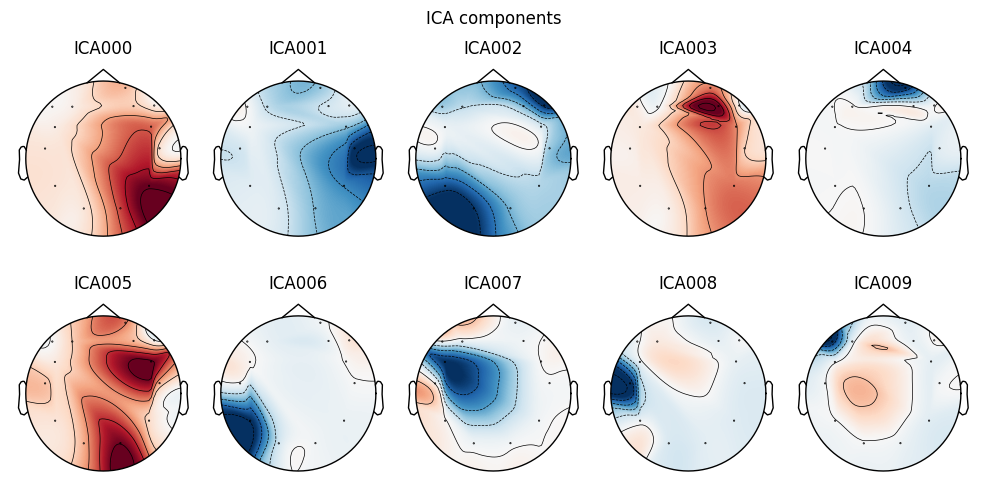

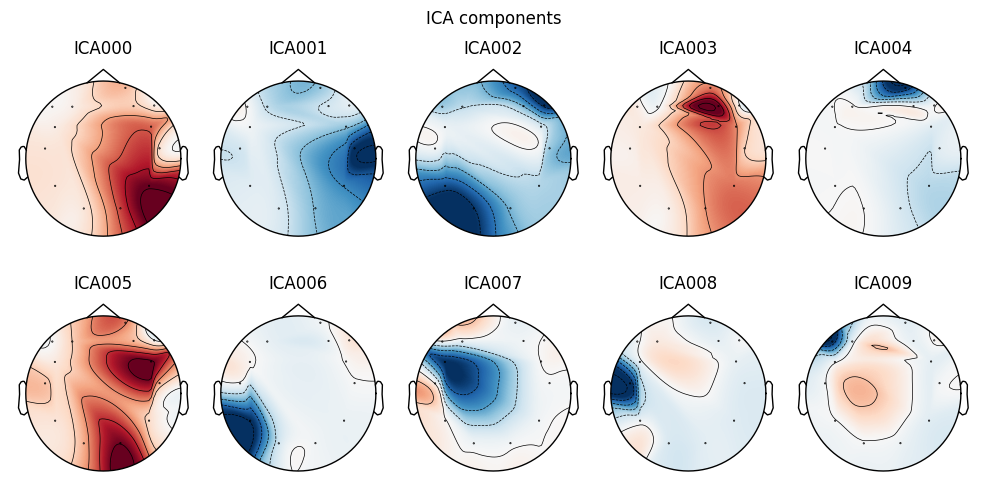

In [15]:
ica = mne.preprocessing.ICA(n_components=10, random_state=0)
ica.fit(raw)
ica.plot_components()

In [16]:
# Exclude components if they are identified as artifacts
#ica.exclude = [4]

# Apply ICA to remove artifacts
raw_cleaned = ica.apply(raw)


# Save the cleaned data
cleaned_data = raw_cleaned.get_data().T
cleaned_df = pd.DataFrame(cleaned_data)

raw_data = raw_cleaned.get_data()
clean_info = raw.info.copy()
clean_raw = mne.io.RawArray(raw_data, clean_info)


Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 13 PCA components
Creating RawArray with float64 data, n_channels=13, n_times=271439
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.


In [17]:
# Save the cleaned data to a file
clean_raw.save('cleaned_data_raw.fif',overwrite=True)

Writing /content/cleaned_data_raw.fif
Closing /content/cleaned_data_raw.fif
[done]


Opening raw data file cleaned_data_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...
Using matplotlib as 2D backend.


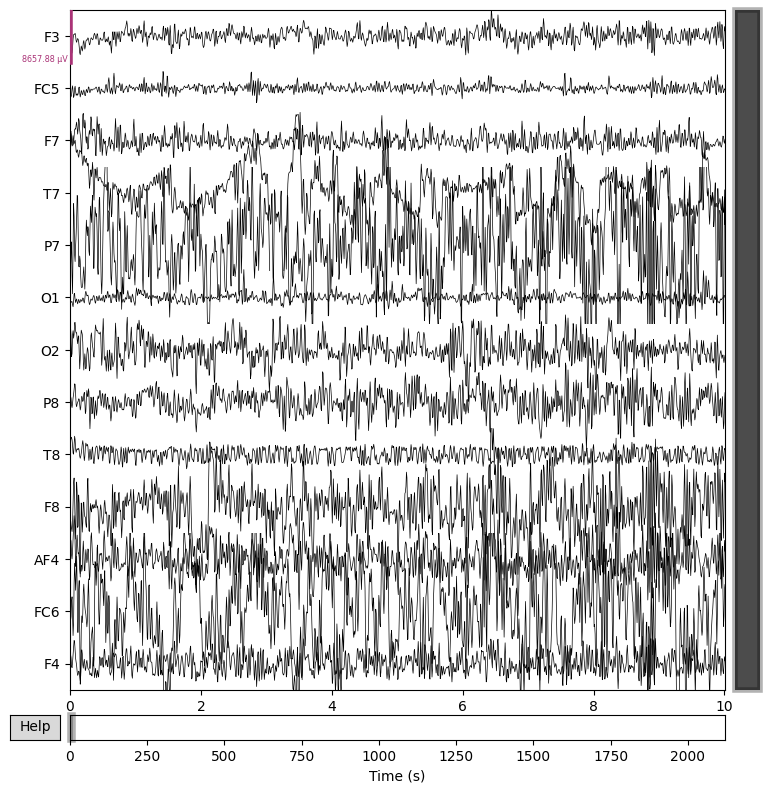

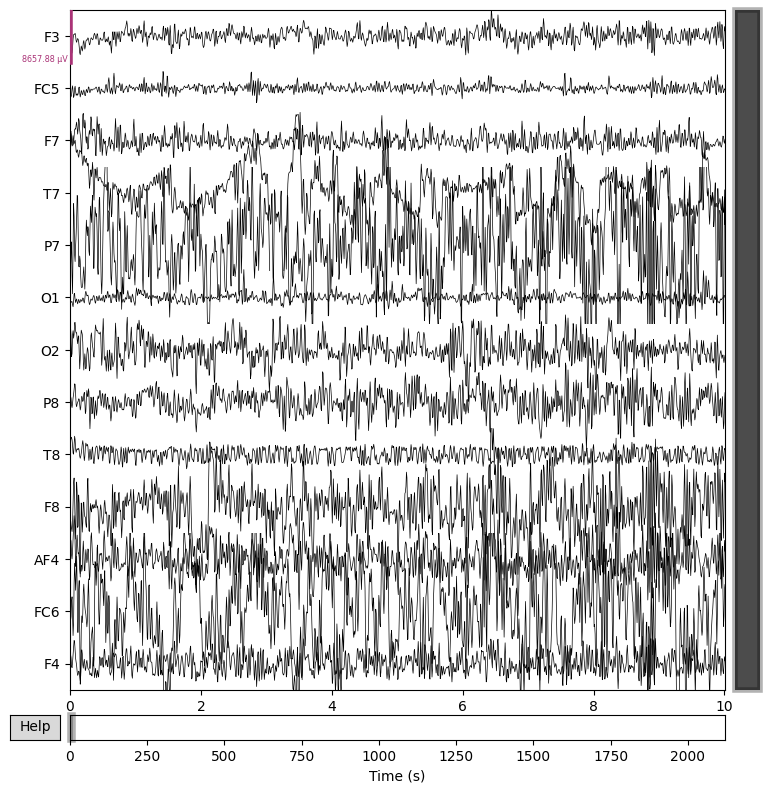

In [18]:
import mne

# Load the cleaned data into an MNE-Python Raw object
raw = mne.io.read_raw_fif('cleaned_data_raw.fif',preload=True)

# Plot raw data before pre-processing
raw.plot(n_channels=13, scalings='auto', title='Before Pre-processing')


In [19]:
target = np.array(target)
print(target.shape)

n_samples = clean_raw.n_times
print(n_samples)
target = target[:n_samples]

(271439,)
271439


In [20]:
import pywt
# Load the cleaned EEG data
raw = mne.io.read_raw_fif('cleaned_data_raw.fif', preload=True)

# Set the desired wavelet and level of decomposition
wavelet = 'db4'
level = 4

# Calculate the DWT coefficients for each channel
coeffs = pywt.wavedec(raw._data, wavelet, level=level)

# Extract the desired features from the DWT coefficients
# Example: Extract the energy of the detail coefficients at level 4
dwt_features = np.sum(coeffs[4]**2, axis=1)

# Add DWT features to raw object
ch_names = [ch_name for ch_name in raw.ch_names if ch_name.startswith('EEG')]
for i, ch_name in enumerate(ch_names):
    raw.rename_channels({ch_name: f'{ch_name}_DWT'})
    raw._data[i] = dwt_features[i]

# Save raw object with DWT features
raw.save('dwt_features_raw.fif', overwrite=True)

Opening raw data file cleaned_data_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...
Writing /content/dwt_features_raw.fif
Closing /content/dwt_features_raw.fif
[done]


In [21]:
import mne
import numpy as np
from scipy import signal

# Load the cleaned EEG data
raw = mne.io.read_raw_fif('cleaned_data_raw.fif', preload=True)

# Define the wavelet and scales
wavelet = 'morl'
scales = np.arange(1, 50)

# Calculate the CWT coefficients for each channel
cwt_coeffs, freqs = pywt.cwt(raw._data, scales, wavelet)

# Example: Calculate the average power of the CWT coefficients
cwt_features = np.mean(cwt_coeffs**2, axis=(1, 2))

# Add CWT features to the raw object
ch_names = [ch_name for ch_name in raw.ch_names if ch_name.startswith('EEG')]
for i, ch_name in enumerate(ch_names):
    raw.rename_channels({ch_name: f'{ch_name}_CWT'})
    raw._data[i] = cwt_features[i]

# Save raw object with CWT features
raw.save('cwt_features_raw.fif', overwrite=True)

Opening raw data file cleaned_data_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...
Writing /content/cwt_features_raw.fif
Closing /content/cwt_features_raw.fif
[done]


In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the spectral features data
data = mne.io.read_raw_fif('dwt_features_raw.fif',preload=True)
X = data.get_data()
X = X.transpose()
y = target

print(X.shape)
print(y.shape)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set and compute accuracy
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Opening raw data file dwt_features_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...
(271439, 13)
(271439,)
Accuracy: 73.60%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Load the spectral features data
data = mne.io.read_raw_fif('dwt_features_raw.fif', preload=True)
X = data.get_data()
X = X.transpose()
y = target

print(X.shape)
print(y.shape)

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train a random forest classifier on each fold and compute accuracy
accs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = RandomForestClassifier(n_estimators=100, random_state=42,verbose=1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

# Compute the mean accuracy and standard deviation across all folds
mean_acc = np.mean(accs)
std_acc = np.std(accs)
print("Mean accuracy: {:.2f}%".format(mean_acc * 100))
print("Standard deviation: {:.2f}%".format(std_acc * 100))

Opening raw data file dwt_features_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...
(271439, 13)
(271439,)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


Mean accuracy: 73.13%
Standard deviation: 0.25%


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
raw = mne.io.read_raw_fif('cwt_features_raw.fif', preload=True)
data = raw.get_data().T
target = np.array(target)

# Reshape the data for LSTM input (samples, time steps, features)
data = data.reshape(data.shape[0], data.shape[1], 1)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(data.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Opening raw data file cwt_features_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.5728 - loss: 0.6830
Epoch 2/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.5740 - loss: 0.6822
Epoch 3/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.5727 - loss: 0.6826
Epoch 4/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.5730 - loss: 0.6825
Epoch 5/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.5750 - loss: 0.6819
Epoch 6/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.5741 - loss: 0.6822
Epoch 7/10
6786/6786 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.5729 - loss: 0.6823
Epoch 8/10
4683/6786 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5751 - loss: 0.6818

KeyboardInterrupt: 

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Deep Neural Network using GRU
# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.1, random_state=42, stratify=y)

# Build GRU Model
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=50, batch_size=32, validation_split=0.1,
                    callbacks=[early_stopping], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - accuracy: 0.5913 - loss: 0.6708 - val_accuracy: 0.6087 - val_loss: 0.6556
Epoch 2/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - accuracy: 0.6109 - loss: 0.6565 - val_accuracy: 0.6163 - val_loss: 0.6485
Epoch 3/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.6152 - loss: 0.6501 - val_accuracy: 0.6212 - val_loss: 0.6425
Epoch 4/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.6207 - loss: 0.6448 - val_accuracy: 0.6238 - val_loss: 0.6371
Epoch 5/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.6202 - loss: 0.6432 - val_accuracy: 0.6272 - val_loss: 0.6335
Epoch 6/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.6223 - loss: 0.6401 - val_accuracy: 0.6279 - val_loss: 0.6309
Epoch 7/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.6291 - loss: 0.6353 - val_accuracy: 0.6324 - val_loss: 0.6276
Epoch 8/50
6871/6871 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.6302 - loss: 0

KeyboardInterrupt: 

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2715/2715 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.5750 - loss: 0.7061 - val_accuracy: 0.6141 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 2/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.6105 - loss: 0.6570 - val_accuracy: 0.6181 - val_loss: 0.6454 - learning_rate: 0.0010
Epoch 3/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6168 - loss: 0.6497 - val_accuracy: 0.6232 - val_loss: 0.6401 - learning_rate: 0.0010
Epoch 4/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.6200 - loss: 0.6460 - val_accuracy: 0.6264 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 5/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6225 - loss: 0.6412 - val_accuracy: 0.6340 - val_loss: 0.6300 - learning_rate: 0.0010
Epoch 6/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6311 - loss: 0.6360 - val_accuracy: 0.6322 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 7/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0

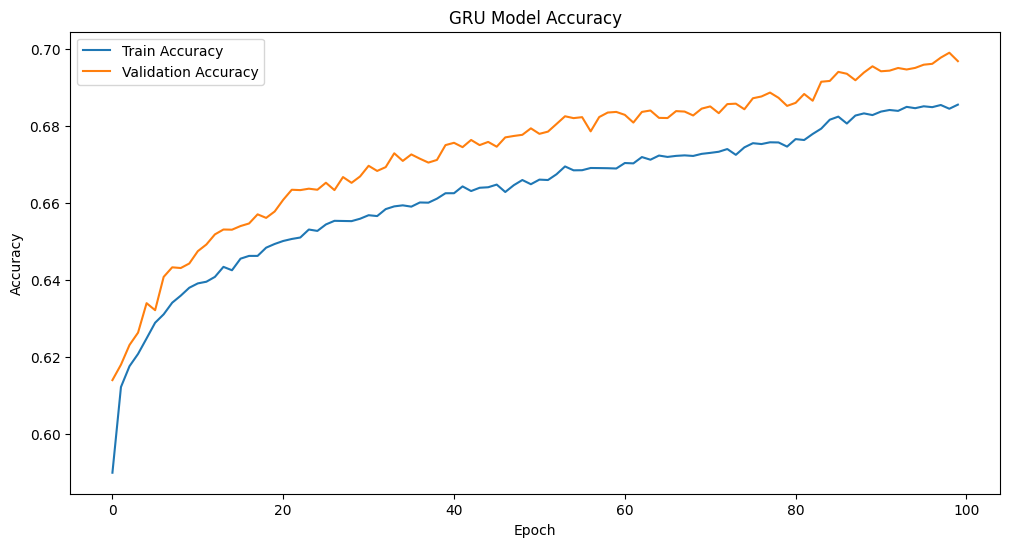

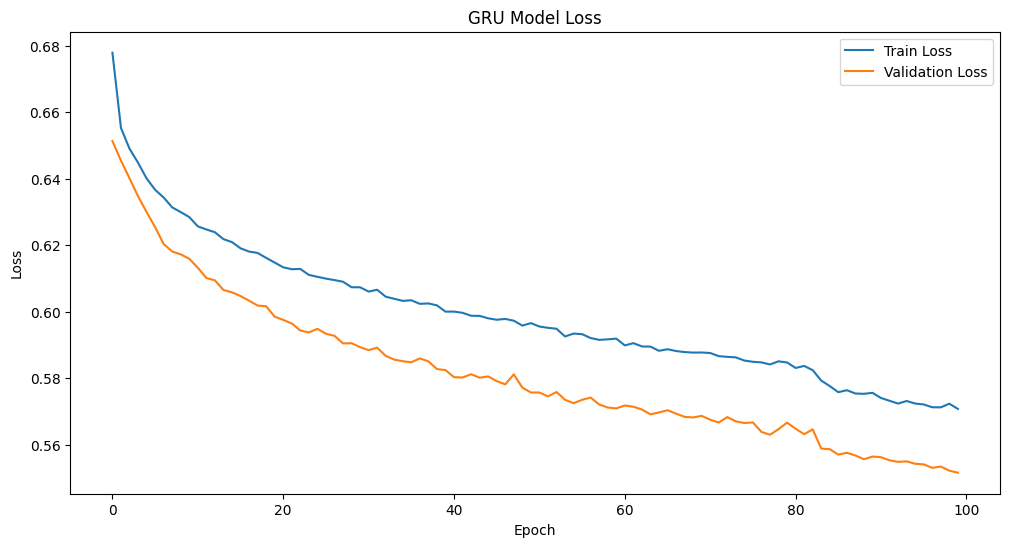

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with improvements
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model.save_weights('model_gru1.weights.h5')
model.save('gru1_model.keras')

In [40]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('gru_model.h5')

# Now you can use the model for further training or evaluation
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         109,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,835 (1.62 MB)

 Trainable params: 423,809 (1.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
##same as above but retrained and saved, trained for 50 more epoches
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with improvements
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save_weights('model_gru11.weights.h5')
model.save('gru11_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('gru11_model.h5')

# Now you can use the model for further training or evaluation
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - accuracy: 0.5966 - loss: 0.6765 - val_accuracy: 0.6448 - val_loss: 0.6236 - learning_rate: 0.0050
Epoch 2/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.6347 - loss: 0.6345 - val_accuracy: 0.6566 - val_loss: 0.6008 - learning_rate: 0.0050
Epoch 3/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.6451 - loss: 0.6231 - val_accuracy: 0.6683 - val_loss: 0.5885 - learning_rate: 0.0050
Epoch 4/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.6553 - loss: 0.6112 - val_accuracy: 0.6805 - val_loss: 0.5807 - learning_rate: 0.0050
Epoch 5/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.6624 - loss: 0.6024 - val_accuracy: 0.6885 - val_loss: 0.5670 - learning_rate: 0.0050
Epoch 6/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6662 - loss: 0.5982 - val_accuracy: 0.6861 - val_loss: 0.5611 - learning_rate: 0.0050
Epoch 7/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step -

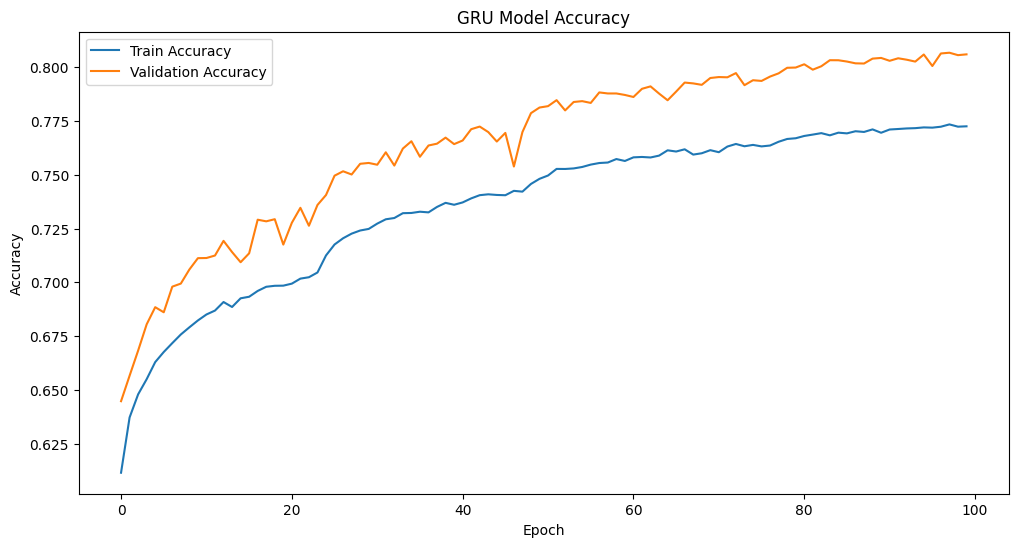

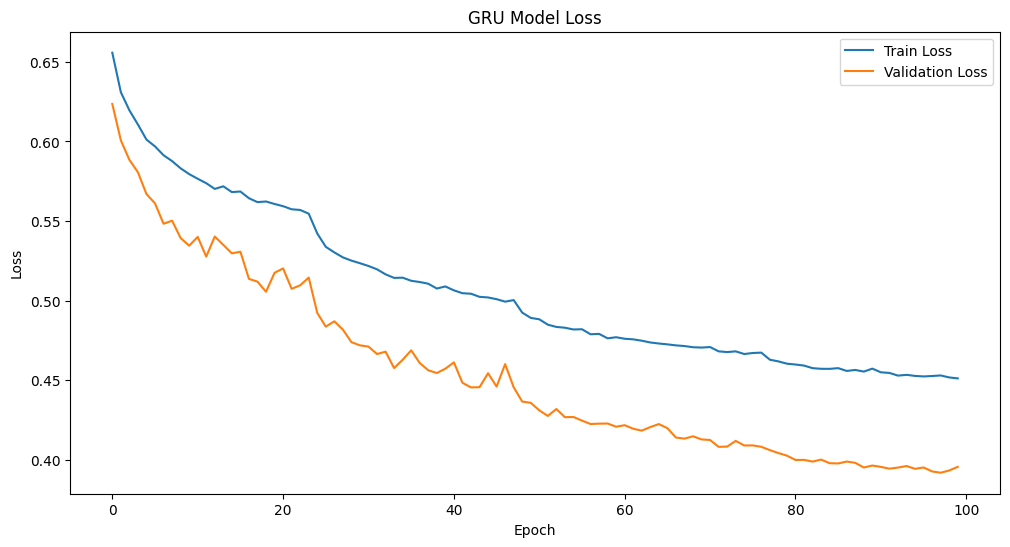

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


y = df.iloc[:,-1]
X = np.array(df.iloc[:,:-3])

# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with improvements
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save_weights('model_gru2.weights.h5')
model.save('gru2_model.keras')

In [42]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('gru2_model.keras')

# Now you can use the model for further training or evaluation
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 1, 256)              │         109,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,272,453 (4.85 MB)

 Trainable params: 423,809 (1.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 847,620 (3.23 MB)

In [46]:
data = mne.io.read_raw_fif('cleaned_data_raw.fif',preload=True)
X = data.get_data()
X = X.transpose()
y = target
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with improvements
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save_weights('model_gru3.weights.h5')
model.save('gru3_model.keras')

Opening raw data file cleaned_data_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.5813 - loss: 0.6921 - val_accuracy: 0.6060 - val_loss: 0.6604 - learning_rate: 0.0050
Epoch 2/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.6009 - loss: 0.6641 - val_accuracy: 0.6118 - val_loss: 0.6555 - learning_rate: 0.0050
Epoch 3/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.6062 - loss: 0.6596 - val_accuracy: 0.6140 - val_loss: 0.6491 - learning_rate: 0.0050
Epoch 4/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.6112 - loss: 0.6572 - val_accuracy: 0.6181 - val_loss: 0.6458 - learning_rate: 0.0050
Epoch 5/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.6085 - loss: 0.6572 - val_accuracy: 0.6144 - val_loss: 0.6511 - learning_rate: 0.0050
Epoch 6/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.6116 - loss: 0.6562 - val_accuracy: 0.6215 - val_loss: 0.6432 - learning_rate: 0.0050
Epoch 7/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step -

KeyboardInterrupt: 

In [47]:
data = mne.io.read_raw_fif('dwt_features_raw.fif',preload=True)
X = data.get_data()
X = X.transpose()
y = target
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with improvements
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Opening raw data file dwt_features_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.5830 - loss: 0.6888 - val_accuracy: 0.6053 - val_loss: 0.6561 - learning_rate: 0.0050
Epoch 2/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.6013 - loss: 0.6639 - val_accuracy: 0.6077 - val_loss: 0.6531 - learning_rate: 0.0050
Epoch 3/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6037 - loss: 0.6607 - val_accuracy: 0.6117 - val_loss: 0.6535 - learning_rate: 0.0050
Epoch 4/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6100 - loss: 0.6581 - val_accuracy: 0.6128 - val_loss: 0.6486 - learning_rate: 0.0050
Epoch 5/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6109 - loss: 0.6568 - val_accuracy: 0.6170 - val_loss: 0.6473 - learning_rate: 0.0050
Epoch 6/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.6133 - loss: 0.6550 - val_accuracy: 0.6198 - val_loss: 0.6434 - learning_rate: 0.0050
Epoch 7/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step -

KeyboardInterrupt: 

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


y = df.iloc[:,-1]
X = np.array(df.iloc[:,:-3])


# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with improvements
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.save_weights('model_lstm2.weights.h5')
model.save('lstm2_model.keras')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2715/2715 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.5849 - loss: 0.6895 - val_accuracy: 0.6063 - val_loss: 0.6581 - learning_rate: 0.0050
Epoch 2/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.6030 - loss: 0.6642 - val_accuracy: 0.6083 - val_loss: 0.6543 - learning_rate: 0.0050
Epoch 3/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.6058 - loss: 0.6607 - val_accuracy: 0.6177 - val_loss: 0.6503 - learning_rate: 0.0050
Epoch 4/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 69s 22ms/step - accuracy: 0.6083 - loss: 0.6592 - val_accuracy: 0.6176 - val_loss: 0.6479 - learning_rate: 0.0050
Epoch 5/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step - accuracy: 0.6124 - loss: 0.6564 - val_accuracy: 0.6165 - val_loss: 0.6496 - learning_rate: 0.0050
Epoch 6/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.6114 - loss: 0.6551 - val_accuracy: 0.6235 - val_loss: 0.6413 - learning_rate: 0.0050
Epoch 7/100
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

data = mne.io.read_raw_fif('cwt_features_raw.fif',preload=True)
X = data.get_data()
X = X.transpose()
y = target

# Scale data for GRU model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42, stratify=y)

# Build GRU Model with revised architecture
model = Sequential()

# Input GRU Layer with Bidirectional GRU
model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model.add(Dropout(0.1))
model.add(BatchNormalization())

# Second GRU Layer
model.add(Bidirectional(GRU(64, return_sequences=False)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting and ReduceLROnPlateau to adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train GRU Model
history = model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate GRU Model
y_pred_gru = (model.predict(X_test_gru) > 0.5).astype("int32")

print("GRU Model Accuracy: {:.2f}%".format(accuracy_score(y_test_gru, y_pred_gru) * 100))
print(classification_report(y_test_gru, y_pred_gru))

# Plot training history for GRU model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save_weights('model_gru4.weights.h5')
model.save('gru4_model.keras')

Opening raw data file cwt_features_raw.fif...
    Range : 0 ... 271438 =      0.000 ...  2120.609 secs
Ready.
Reading 0 ... 271438  =      0.000 ...  2120.609 secs...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.5835 - loss: 0.6811 - val_accuracy: 0.6042 - val_loss: 0.6570 - learning_rate: 0.0050
Epoch 2/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.6072 - loss: 0.6588 - val_accuracy: 0.6146 - val_loss: 0.6504 - learning_rate: 0.0050
Epoch 3/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.6113 - loss: 0.6554 - val_accuracy: 0.6176 - val_loss: 0.6512 - learning_rate: 0.0050
Epoch 4/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.6129 - loss: 0.6529 - val_accuracy: 0.6164 - val_loss: 0.6465 - learning_rate: 0.0050
Epoch 5/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.6168 - loss: 0.6509 - val_accuracy: 0.6219 - val_loss: 0.6422 - learning_rate: 0.0050
Epoch 6/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.6184 - loss: 0.6476 - val_accuracy: 0.6234 - val_loss: 0.6426 - learning_rate: 0.0050
Epoch 7/100
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step -